In [281]:
! pip install numpy
! pip install pandas
! pip install matplotlib
! pip install lxml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr 

%matplotlib
%matplotlib inline

Using matplotlib backend: QtAgg


In [282]:
#начальное представление данных
df_raw = pd.read_csv("D:\Pasha/game.csv")
df_raw

,game_id,season,type,date_time_GMT,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue,venue_link,venue_time_zone_id,venue_time_zone_offset,venue_time_zone_tz
0,2016020045,20162017,R,2016-10-19T00:30:00Z,4,16,4,7,home win REG,right,United Center,/api/v1/venues/null,America/Chicago,-5,CDT
1,2017020812,20172018,R,2018-02-07T00:00:00Z,24,7,4,3,away win OT,left,KeyBank Center,/api/v1/venues/null,America/New_York,-4,EDT
2,2015020314,20152016,R,2015-11-24T01:00:00Z,21,52,4,1,away win REG,right,MTS Centre,/api/v1/venues/null,America/Winnipeg,-5,CDT
3,2015020849,20152016,R,2016-02-17T00:00:00Z,52,12,1,2,home win REG,right,PNC Arena,/api/v1/venues/null,America/New_York,-4,EDT
4,2017020586,20172018,R,2017-12-30T03:00:00Z,20,24,1,2,home win REG,left,Honda Center,/api/v1/venues/null,America/Los_Angeles,-7,PDT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26300,2018030415,20182019,P,2019-06-07T00:00:00Z,19,6,2,1,away win REG,left,TD Garden,/api/v1/venues/5085,America/New_York,-5,EST
26301,2018030416,20182019,P,2019-06-10T00:00:00Z,6,19,5,1,away win REG,left,Enterprise Center,/api/v1/venues/5076,America/Chicago,-6,CST
26302,2018030416,20182019,P,2019-06-10T00:00:00Z,6,19,5,1,away win REG,left,Enterprise Center,/api/v1/venues/5076,America/Chicago,-6,CST
26303,2018030417,20182019,P,2019-06-13T00:00:00Z,19,6,4,1,away win REG,left,TD Garden,/api/v1/venues/5085,America/New_York,-5,EST


        2.
    a) предметная область:   хоккейные матчи NHL
       источник данных:      kaggle (ссылка на датасет: https://www.kaggle.com/datasets/martinellis/nhl-game-data/data )
       характер данных:      реальные
       
    b) атрибуты:
        game_id:                 id матча                                        тип: целочисленный
        season:                  сезон матча (с какого по какой год)             тип: целочисленный
        type:                    не понятно :)                                   тип: строковый       (в исслед-ии не использую)
        date_time_GMT:           дата проведения матча                           тип: строковый
        away_team_id:            id команды гостей                               тип: целочисленный
        home_team_id:            id команды хозяев                               тип: целочисленный
        away_goals:              кол-во голов гостей                             тип: целочисленный
        home_goals:              кол-во голов хозяев                             тип: целочисленный
        outcome:                 результат матча (ничьи не бывает)               тип: строковый
        venue:                   место проведения матча                          тип: строковый       (в исслед-ии не использую)
        venue_link:              ссылка на сайт места проведения                 тип: строковый       (в исслед-ии не использую)
        venue_time_zone_id:      штаты команды хозяев/гостей                     тип: строковый       (в исслед-ии не использую)
        venue_time_zone_offset   разница во времени между штатами гост.-хоз.     тип: целочисленный
        venue_time_zone_tz       не понятно                                      тип: строковый       (в исслед-ии не использую)
        
    c) описание задачи анализа:
        найти закономерности в поведении атрибутов, их зависимости друг от друга, для того чтобы в дальнейшем обучить машину предсказывать результат матча :)
        в частности выяснить есть ли какая то связь среди всевозможных пар аттрибутов: результат матча, разница во времени
        разница в голах (гостей и хозяев), сторон с которых играют команды. На эти вопросы можно будет ответив проанализировав
        коэффициенты корреляции между всевозможными парами атрибутов

In [283]:
#подготовка данных к исследованию:

df = df_raw.copy(deep=True)
#разбиваем дату на отдельные части (время, день, год)
df["time"] = df["date_time_GMT"].apply(lambda x: int(x[11:13])*60 + int(x[14:16]))
df["date"] = df["date_time_GMT"].apply(lambda x: (int(x[5:7])*30 + int(x[8:10]) - 30))
df["year"] = df["date_time_GMT"].apply(lambda x: int(x[0:4]))

#изменяем форму записи сезона (на год начала сезона)
df["season"] = df["season"].apply(lambda x: int(x*10**(-4)))

#находим дату начала сезона
df_start_season = df[df['season'] == df['year']].groupby(['season']).agg({'date':min}).agg({'date':min}).iloc[0]

#изменяем форму записи даты (делаем её относительно начала сезона)
df["date"][df['season'] == df['year']] -= df_start_season
df["date"][df['season'] != df['year']] += 362 - df_start_season

#преобразование строковых данных в численное представление для удобства в их обработке
df['outcome'] = np.where(df['outcome'] == "home win REG", 1, 0)
df['home_rink_side_start'] = np.where(df['home_rink_side_start'] == "left", 1, 0)
df['diff_goals'] = df['home_goals'] - df['away_goals']


#удаляем ненужные для анализа и повторяющиеся данные
del df['date_time_GMT']
del df['year']
del df['venue_time_zone_tz']
del df['venue_link']
del df['venue_time_zone_id']
del df['venue']
del df['type']
df

C:\Users\GACHISLAVE\AppData\Local\Temp\ipykernel_6164\4222333116.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"][df['season'] == df['year']] -= df_start_season
C:\Users\GACHISLAVE\AppData\Local\Temp\ipykernel_6164\4222333116.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"][df['season'] != df['year']] += 362 - df_start_season


,game_id,season,away_team_id,home_team_id,away_goals,home_goals,outcome,home_rink_side_start,venue_time_zone_offset,time,date,diff_goals
0,2016020045,2016,4,16,4,7,1,0,-5,30,20,3
1,2017020812,2017,24,7,4,3,0,1,-4,0,130,-1
2,2015020314,2015,21,52,4,1,0,0,-5,60,55,-3
3,2015020849,2015,52,12,1,2,1,0,-4,0,140,1
4,2017020586,2017,20,24,1,2,1,1,-7,180,91,1
...,...,...,...,...,...,...,...,...,...,...,...,...
26300,2018030415,2018,19,6,2,1,0,1,-5,0,250,-1
26301,2018030416,2018,6,19,5,1,0,1,-6,0,253,-4
26302,2018030416,2018,6,19,5,1,0,1,-6,0,253,-4
26303,2018030417,2018,19,6,4,1,0,1,-5,0,256,-3


In [284]:
#3.    a) среднее значение атрибутов
df.mean()

game_id                   2.010765e+09
season                    2.010744e+03
away_team_id              1.687938e+01
home_team_id              1.688143e+01
away_goals                2.687968e+00
home_goals                2.958981e+00
outcome                   4.279034e-01
home_rink_side_start      4.441361e-01
venue_time_zone_offset   -5.066147e+00
time                      3.782718e+02
date                      1.073293e+02
diff_goals                2.710131e-01
dtype: float64

In [285]:
#3.    а) стандартное отклонение атрибутов
df.std()

game_id                   6.073568e+06
season                    6.073241e+00
away_team_id              1.118492e+01
home_team_id              1.120563e+01
away_goals                1.619068e+00
home_goals                1.689031e+00
outcome                   4.947842e-01
home_rink_side_start      4.968789e-01
venue_time_zone_offset    1.210145e+00
time                      5.484144e+02
date                      6.140765e+01
diff_goals                2.392797e+00
dtype: float64

In [286]:
#гистограммы
def histog(atr):
    ser = df[atr]
    plt.figure(figsize=(7, 3))
    plt.hist(ser, bins = 30)
    plt.grid(True)
    plt.title(atr)

In [287]:
#выбросы
def get_outliers(atr):
    bp = df[atr].plot.box(return_type = 'both').lines['fliers'] #получаю фигуру с точками выброса
    outl = [flier.get_ydata() for flier in bp][0] #получаю значения точек выброса
    if len(outl):
        #return (df[df[col].isin(outl)])
        print(outl)
    else: 
        #return('Нет выбросов')
        print('Нет выбросов')

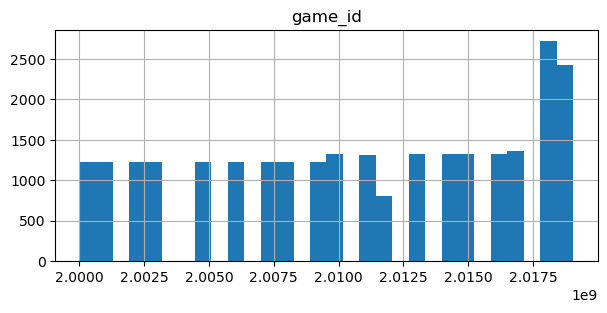

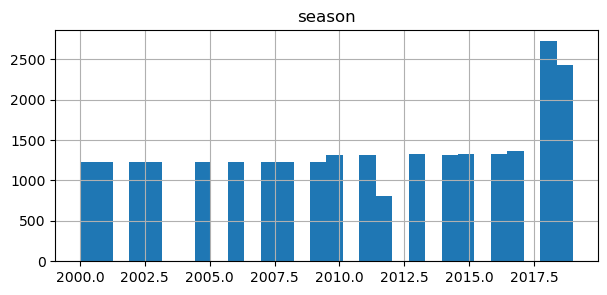

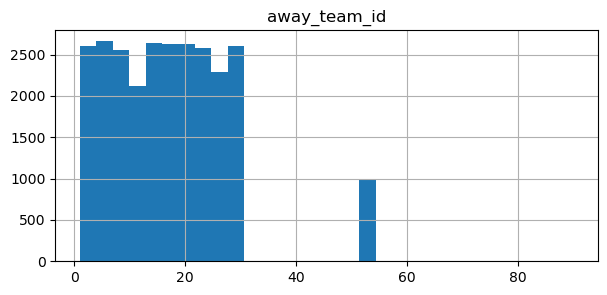

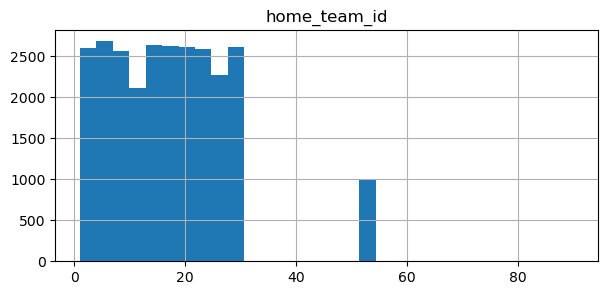

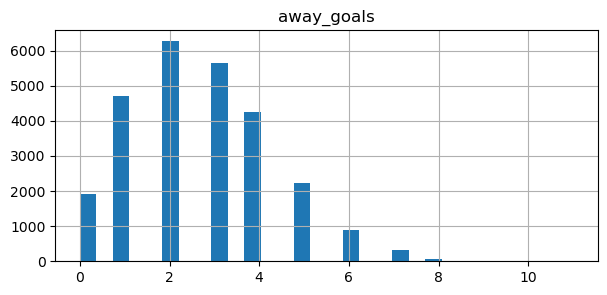

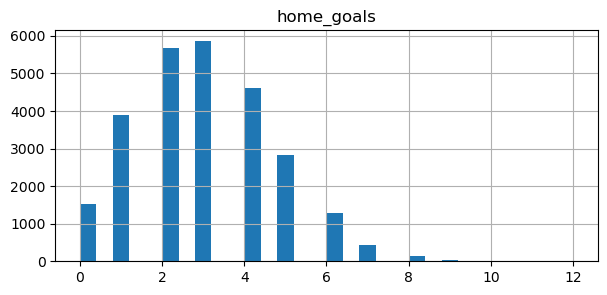

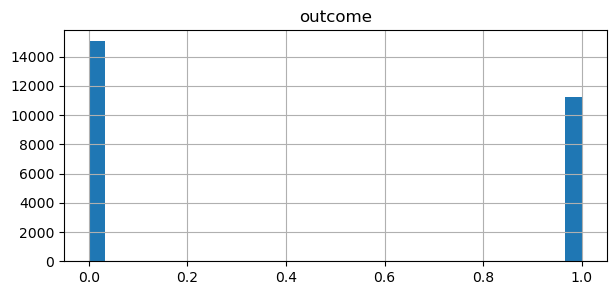

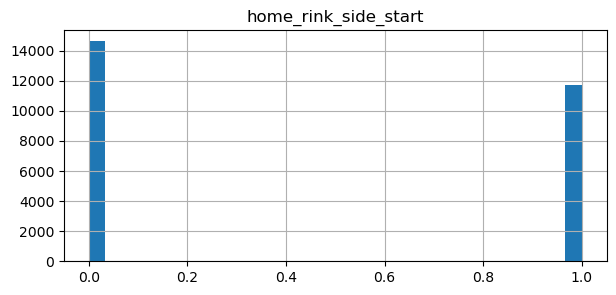

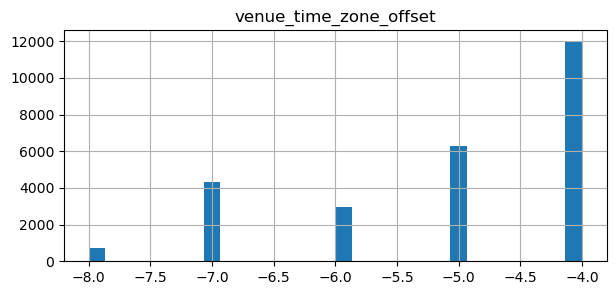

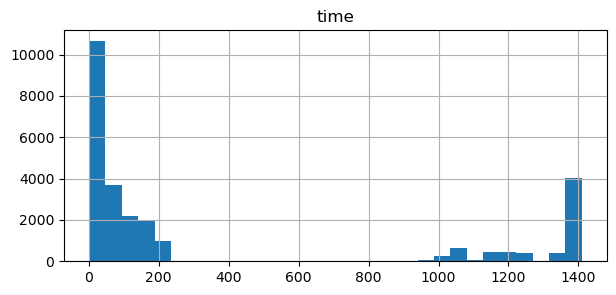

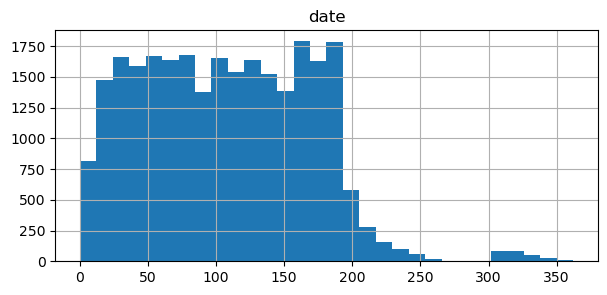

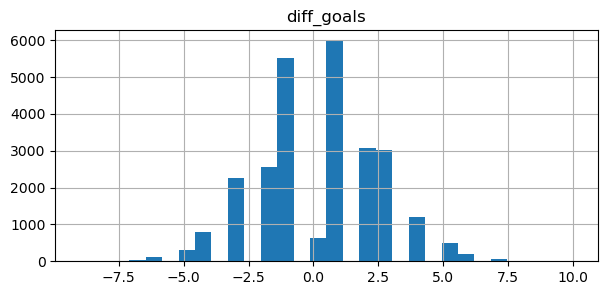

In [288]:
# 3    b) построение гистограмм для всех атрибутов
for atr in df.columns:
    histog(atr)

game_id : Нет выбросов
season : Нет выбросов
away_team_id : [52 52 52 ... 52 54 54]
home_team_id : [52 53 53 ... 52 54 54]
away_goals : [ 9  9  9  9  9 10  9  9 10  9  9 10  9  9  9  9 10  9  9 11 10 10 10  9
  9  9  9 10 10]
home_goals : [ 8  8  8  8 10  8  8  8  8 10  8  8  8  8  8 10  8  8  8  8 10  8  8  8
  8  8  8  9  9  8  9  8  8  8  8  9  8  8  8  8  8  8  8  8  8  9  9  8
  8  8  9  8  8  8  9  8  8  8  8  8  8  8  9  8  8  8  8  9  8  8 10  8
  8  8  8  9  8  8 10  8 10  8  8  9  9  8  8  8  9  8  8  8  8  9  8  8
  8  9 12  8  8  8  8  8  8  8  9  8  8  8  9  8  9  8  8  8  9  8 10  8
  8  9  8  8  8  8  8  9  8  8  9  8  8  8  8  8  8  8  8  8  8  8  8 10
  8  8  8  8  8  9  9  8  8  9  9  8  8  8  8  9  9  8  8  8  8  9  9  9
  9  8  8  8  8  8  8  8  8  8  8  9  9  8  8  8  8  8  8  9  9  8  8  8
  8  8  8  9  9  8  8]
outcome : Нет выбросов
home_rink_side_start : Нет выбросов
venue_time_zone_offset : Нет выбросов
time : Нет выбросов
date : [309 309 309 309 309 309 309 3

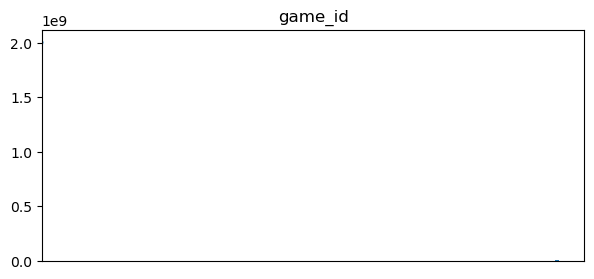

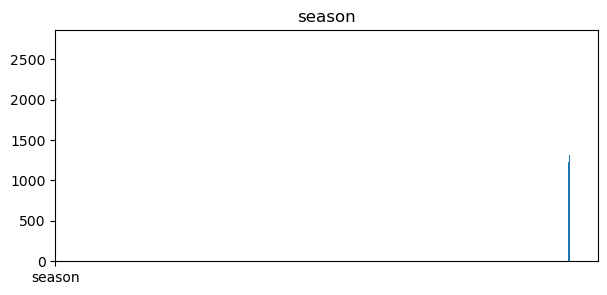

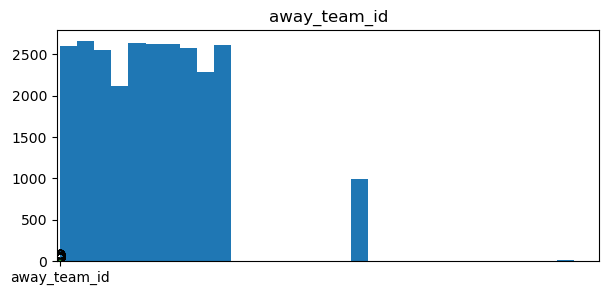

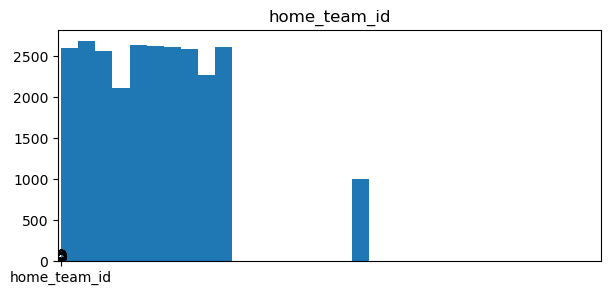

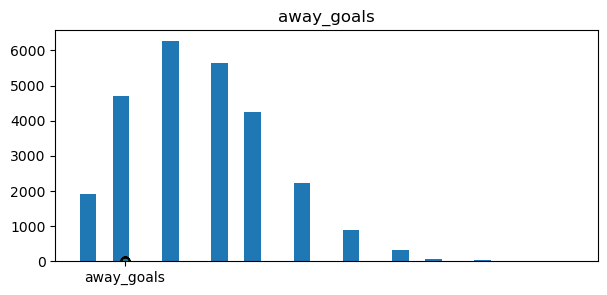

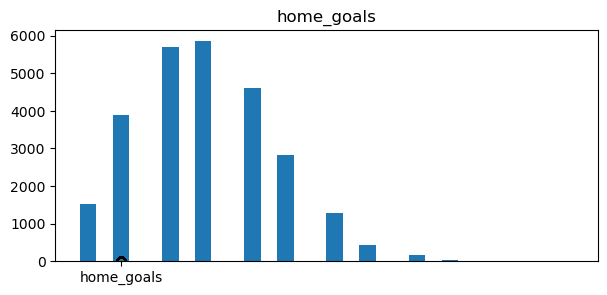

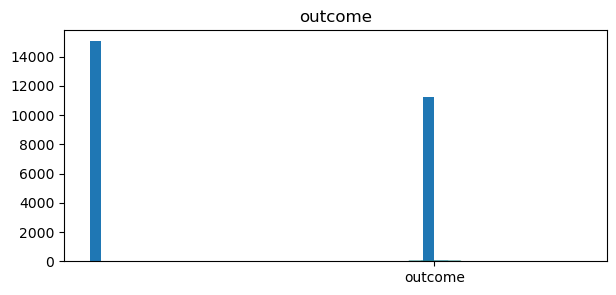

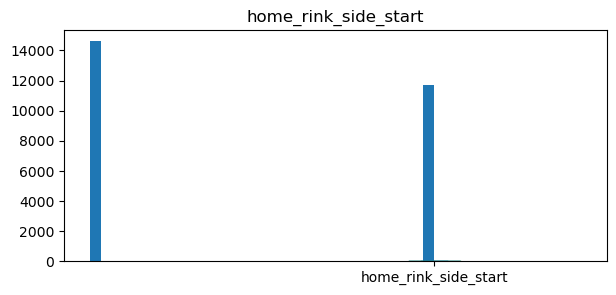

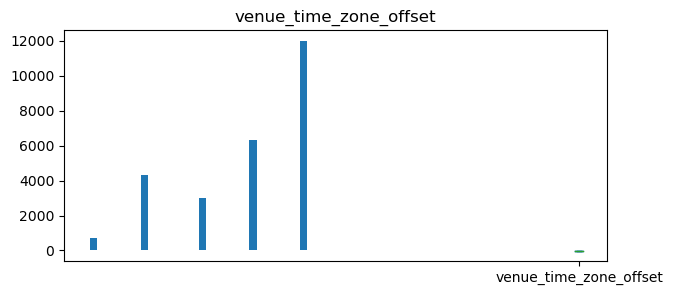

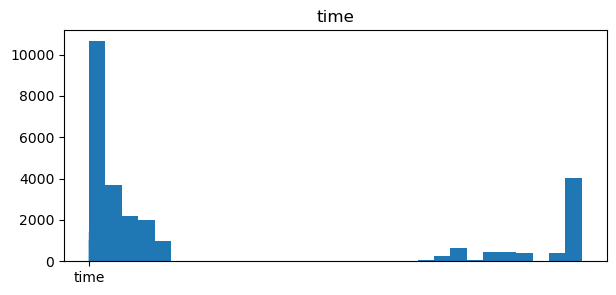

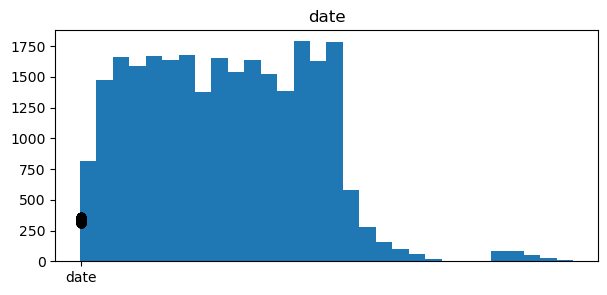

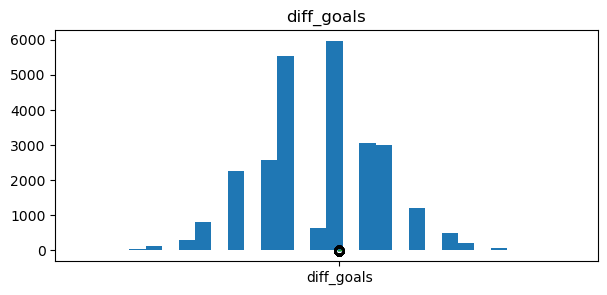

In [289]:
#3.    b) выбросы
'''здесь костыль: если на каждой итерации не выводить гистограмму, то код ломается,
    поэтому, приходится второй раз строить те же графики, не смотря на то, что нам здесь нужны только выбросы.
    гистограммы тоже строятся здесь неверно, поэтому в ячейке выше, я не стал одним циклом выводить и гистограммы
    и выбросы. 
    
    Буду очень признателен, если Вы подскажете, в чем может быть проблема, у меня не получилось разобраться :)
    
'''
for atr in df.columns:
    print(atr, ':', end=' ')
    histog(atr)                            #если закомментить эту строку код сломается
    get_outliers(atr)


In [290]:
#3.     c) пропущенные значения
df.isna().sum()


game_id                   0
season                    0
away_team_id              0
home_team_id              0
away_goals                0
home_goals                0
outcome                   0
home_rink_side_start      0
venue_time_zone_offset    0
time                      0
date                      0
diff_goals                0
dtype: int64

#3.     d) вариант обработки пропущенных значений.

Как видим во всем коде нет пропущенных значений. Если бы они были, то как вариант обработки, можно было бы заменить каждое
пропущенное значение в столбце на его среднее значение по тому же столбцу, чтобы не удалять полностью строки с пропущенными
значениями и пропущенные значения не влияли существенно на все распределенние. Хотя основные статистические характеристики 
через метод describe() мы бы все равно смогли получить, так как данный метод автоматически пропускает NaN

array([[<Axes: xlabel='game_id', ylabel='game_id'>,
        <Axes: xlabel='season', ylabel='game_id'>,
        <Axes: xlabel='away_team_id', ylabel='game_id'>,
        <Axes: xlabel='home_team_id', ylabel='game_id'>,
        <Axes: xlabel='away_goals', ylabel='game_id'>,
        <Axes: xlabel='home_goals', ylabel='game_id'>,
        <Axes: xlabel='outcome', ylabel='game_id'>,
        <Axes: xlabel='home_rink_side_start', ylabel='game_id'>,
        <Axes: xlabel='venue_time_zone_offset', ylabel='game_id'>,
        <Axes: xlabel='time', ylabel='game_id'>,
        <Axes: xlabel='date', ylabel='game_id'>,
        <Axes: xlabel='diff_goals', ylabel='game_id'>],
       [<Axes: xlabel='game_id', ylabel='season'>,
        <Axes: xlabel='season', ylabel='season'>,
        <Axes: xlabel='away_team_id', ylabel='season'>,
        <Axes: xlabel='home_team_id', ylabel='season'>,
        <Axes: xlabel='away_goals', ylabel='season'>,
        <Axes: xlabel='home_goals', ylabel='season'>,
        <Axes:

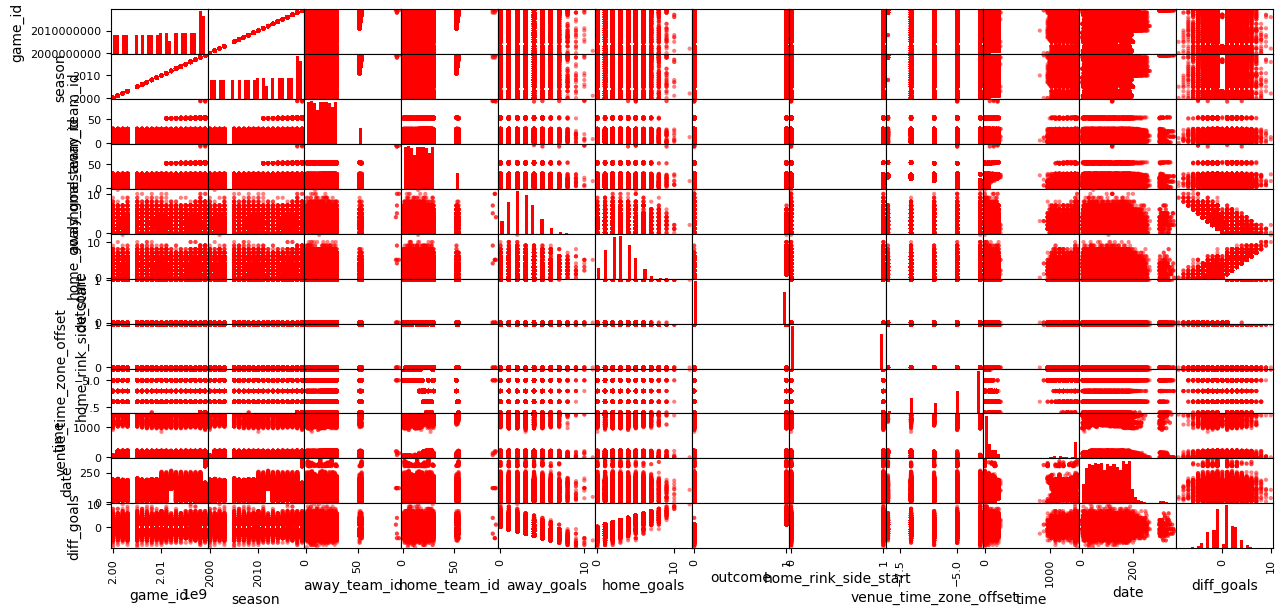

In [291]:
#4.

m = pd.plotting.scatter_matrix(df, color='red', figsize=(15, 7), hist_kwds={'bins': 30 , 'color':'red'})
m


In [292]:
# характера и степено корреляции
atr = df.columns
sizeAtr = len(atr)
for i in range(sizeAtr):
    for j in range(i+1, sizeAtr):
        k_kor = df.iloc[:, i].corr(df.iloc[:, j])
        print(atr[i], ":", atr[j], "\t\t\t", k_kor, end = '\t')
        if (abs(k_kor) < 0.3):
            print("очень слабая", end = ' ')
        elif (0.3 <= abs(k_kor) < 0.5 ):
            print("слабая", end = ' ')
        elif (0.5 <= abs(k_kor) < 0.7 ):
            print("средняя", end = ' ')
        elif (0.7 <= abs(k_kor) < 0.9 ):
            print("высокая", end = ' ')
        else:
            print("очень высокая", end = ' ')
            
        if (k_kor < 0):
            print("отрицательная")
        else:
            print(" ")
    


game_id : season 			 0.9999999457506575	очень высокая  
game_id : away_team_id 			 0.1220269804267778	очень слабая  
game_id : home_team_id 			 0.12197403419398894	очень слабая  
game_id : away_goals 			 0.045445839663593564	очень слабая  
game_id : home_goals 			 0.03794632168573264	очень слабая  
game_id : outcome 			 -0.00347061532505865	очень слабая отрицательная
game_id : home_rink_side_start 			 0.020177199760353898	очень слабая  
game_id : venue_time_zone_offset 			 -0.20008940322425894	очень слабая отрицательная
game_id : time 			 0.06544318963696248	очень слабая  
game_id : date 			 0.057128416376081056	очень слабая  
game_id : diff_goals 			 -0.003964984286911841	очень слабая отрицательная
season : away_team_id 			 0.12202160765356719	очень слабая  
season : home_team_id 			 0.12196697561071046	очень слабая  
season : away_goals 			 0.04544837806378265	очень слабая  
season : home_goals 			 0.03795746045653418	очень слабая  
season : outcome 			 -0.003465575091019161	очень сл

Для определения силы и характера корреляции я использовал
шкалу Чеддока (таблица анализа силы связи между переменными):

     Значение:	   Интерпретация:
     0   - 0,3	   очень слабая
     0,3 - 0,5	   слабая
     0,5 - 0,7	   средняя
     0,7 - 0,9	   высокая
     0,9 - 1	   очень высокая

Выводы:


Результаты не оправдали моих ожиданий. Единственная связь прослеживается между количеством заброшенных шайб комманды и результатом матча, и то эта связь средняя. Ну и между разницей в голах и результатом, что и без анализа понятно. Результат матча  по этим данным не зависит ни от того насколько поздно проходит матч, ни от того с каких сторон начинают команды, ни от того как близко к концу сезона проходит матч. Разница во времени так же никак не влияет на результат матча. Но интересно среднее значение результата матча, равное 0.43... < 0.5, что означает что в 43% побеждают гости на чужой арене. Изначально я предполагал обратное. В целом такие результаты анализа очевидны, в следствие с малым количеством входных данных. В исследовании не учитываются ни рейтинг команд по таблице, ни их состав, тренеров и другие важные данные. Возможно если проанализировать матчи между примерно одинаковыми по силе командами, то какая-нибудь зависимость, не обнаруженная в моих исследованиях, появится. Данная работы была полезна с точки зрения обучения студента, а не машины :)